In [2]:
# 필요한 패키지 
!pip install transformers
!pip install gTTS


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [1]:
# IMPORT

from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import torch
from PIL import Image
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import DataCollatorForSeq2Seq
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from gtts import gTTS
from IPython.display import Audio
from IPython.display import display
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Model 
# Vit-Gpt
model_vitgpt = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer_vitgpt = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
model_vitgpt.to(device)


# Ko-En Translation
#모델 저장 되어 있는 경로 지정
model_dir = "/Users/baesangjun/Desktop/SWProject/result2"
tokenizer_trans = AutoTokenizer.from_pretrained(model_dir)
model_trans = AutoModelForSeq2SeqLM.from_pretrained(model_dir)
model_trans.cpu()
max_token_length = 64


In [3]:
model_vitgpt

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

In [4]:
model_trans

T5ForConditionalGeneration(
  (shared): Embedding(64128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(64128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo):

In [5]:
# vit-gpt2
max_length = 20
num_beams = 9
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}
def predict_step(image_paths):
  images = []
  for image_path in image_paths:
    i_image = Image.open(image_path)
    if i_image.mode != "RGB":
      i_image = i_image.convert(mode="RGB")

    images.append(i_image)

  pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
  pixel_values = pixel_values.to(device)

  output_ids = model_vitgpt.generate(pixel_values, **gen_kwargs)

  preds = tokenizer_vitgpt.batch_decode(output_ids, skip_special_tokens=True)
  preds = [pred.strip() for pred in preds]
  return preds

def ViT_GPT2(img):
  output=predict_step(img)
  return output

In [6]:
# Translation
def Translation(output):
    input_text = output
    inputs = tokenizer_trans(input_text, return_tensors="pt",
                   padding=True, max_length=max_token_length)
    koreans = model_trans.generate(
        **inputs,max_length=max_token_length,num_beams=5,)
    preds = tokenizer_trans.batch_decode(koreans, skip_special_tokens=True)
    return preds


In [7]:
#tts
def TTS(output):
    text = output[0]
    tts = gTTS(text,lang='ko')
    tts.save('hi.mp3')
    wn = Audio('hi.mp3',autoplay = True)
    display(wn)

In [9]:
# GOGO
img1 = ['/Users/baesangjun/Desktop/SWProject/images/test1.jpg'] 
TTS(Translation(ViT_GPT2(img1)))

/Users/baesangjun/miniforge3/envs/DEEP/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


In [15]:
output = ViT_GPT2(img1)
output

['men playing a game of soccer']

In [16]:
output = Translation(output)
output

/Users/baesangjun/miniforge3/envs/DEEP/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


['남자들은 축구 시합을 해요.']

# Test

In [10]:
# Vit-Gpt2 30장 테스트
sentences = []
for i in range(1,31):
    img = [f'/Users/baesangjun/Desktop/SWProject/images/test{i}.jpg']
    sen = ViT_GPT2(img)
    sentences.append(sen)


In [14]:
sentences

[['men playing a game of soccer'],
 ['a person walking a dog on a sidewalk'],
 ['a man holding a basketball on top of a basketball court'],
 ['a baseball player pitching a ball on top of a field'],
 ['three women sitting at a table with plates of food'],
 ['a laptop computer sitting on top of a desk'],
 ['a female tennis player in action on the court'],
 ['a woman holding a cell phone in front of her face'],
 ['a large jetliner sitting on top of an airport tarmac'],
 ['a baby sitting in a high chair eating a carrot'],
 ['a pizza sitting on top of a white plate'],
 ['a large elephant walking across a dry grass field'],
 ['a large elephant standing in a grassy field'],
 ['motorcycles are parked in a parking lot'],
 ['a man and a woman are sitting on a couch'],
 ['a woman and a man standing in a kitchen'],
 ['people riding skis on top of a snow covered slope'],
 ['a baseball player sliding into a base during a game'],
 ['a man riding skis down a snow covered slope'],
 ['a woman riding a s

In [16]:
kor = []
for i in range(len(sentences)):
    ko = Translation(sentences[i])
    kor.append(ko)

kor

/Users/baesangjun/miniforge3/envs/DEEP/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


[['남자들끼리 축구 시합을 해요.'],
 ['한 사람이 인도에서 개를 걷고 있습니다.'],
 ['농구장 꼭대기에 농구장을 들고 있는 남성이 있다.'],
 ['야구 선수가 운동장 위에 공을 던지는 모습이 포착됐다.'],
 ['세 여성이 음식 접시가 놓인 테이블에 앉아 있다.'],
 ['책상 위에 앉아 있는 노트북 컴퓨터입니다.'],
 ['여자 테니스 선수가 코트에서 액션을 펼치고 있다.'],
 ['한 여성이 휴대전화 한 대를 얼굴 앞에 들고 있다.'],
 ['공항 활주로 위에 앉아 있는 대형 제트라이너입니다.'],
 ['높은 의자에 앉은 아기가 당근을 먹고 있다.'],
 ['하얀 접시 위에 앉아 있는 피자입니다.'],
 ['마른 잔디밭을 건너는 커다란 코끼리가 지나가고 있다.'],
 ['잔디밭에 서 있는 큰 코끼리가 큰 코끼리입니다.'],
 ['주차장에 오토바이가 주차되어 있습니다.'],
 ['한 남자와 한 여자가 소파에 앉아 있다.'],
 ['부엌에 서 있는 여성과 남성이 있다.'],
 ['눈이 덮인 경사로 위에 스키를 타는 사람들이 있습니다.'],
 ['야구 선수가 경기 중 베이스에 미끄러지며 미끄러지고 있다.'],
 ['눈이 덮인 경사로에서 스키를 타던 한 남성이 슬로프를 타고 있다.'],
 ['한 여성이 파도 위에 서핑보드를 타고 있다.'],
 ['흰 곰곰 옆에 앉은 갈색 곰곰이 하얀 곰곰 옆에 앉아 있다.'],
 ['음식을 먹고 있는 남자가 있습니다.'],
 ['검은색과 흰색의 고양이와 흰색과 갈색의 강아지가 있습니다.'],
 ['공항 활주로 위에 앉아 있는 전투기가 있다.'],
 ['한 남성이 동물원에서 기린을 먹이고 있다.'],
 ['자전거 좌석 위에 앉아 있는 고양이가 있습니다.'],
 ['모래바다 위에 앉아 있는 보트가 있습니다.'],
 ['야채와 쌀로 가득 찬 흰 접시에 야채와 밥이 얹어져 있습니다.'],
 ['바로 앞에 피자가 놓인 테이블에 앉아 있는 한 남성이 있다.'],
 ['두 마리의 기린이 한 밭에 나란히 서 있다.']]

In [27]:
import time
t = []
for i in range(30):
    start = time.time()
    img = [f'/Users/baesangjun/Desktop/SWProject/images/test{i+1}.jpg']
    TTS(Translation(ViT_GPT2(img)))
    end = time.time()
    tt = end - start
    t.append(tt)

/Users/baesangjun/miniforge3/envs/DEEP/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


/Users/baesangjun/miniforge3/envs/DEEP/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


/Users/baesangjun/miniforge3/envs/DEEP/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


/Users/baesangjun/miniforge3/envs/DEEP/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


/Users/baesangjun/miniforge3/envs/DEEP/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


/Users/baesangjun/miniforge3/envs/DEEP/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


/Users/baesangjun/miniforge3/envs/DEEP/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


/Users/baesangjun/miniforge3/envs/DEEP/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


/Users/baesangjun/miniforge3/envs/DEEP/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


/Users/baesangjun/miniforge3/envs/DEEP/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


/Users/baesangjun/miniforge3/envs/DEEP/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


/Users/baesangjun/miniforge3/envs/DEEP/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


/Users/baesangjun/miniforge3/envs/DEEP/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


/Users/baesangjun/miniforge3/envs/DEEP/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


/Users/baesangjun/miniforge3/envs/DEEP/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


/Users/baesangjun/miniforge3/envs/DEEP/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


/Users/baesangjun/miniforge3/envs/DEEP/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


/Users/baesangjun/miniforge3/envs/DEEP/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


/Users/baesangjun/miniforge3/envs/DEEP/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


/Users/baesangjun/miniforge3/envs/DEEP/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


/Users/baesangjun/miniforge3/envs/DEEP/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


/Users/baesangjun/miniforge3/envs/DEEP/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


/Users/baesangjun/miniforge3/envs/DEEP/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


/Users/baesangjun/miniforge3/envs/DEEP/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


/Users/baesangjun/miniforge3/envs/DEEP/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


/Users/baesangjun/miniforge3/envs/DEEP/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


/Users/baesangjun/miniforge3/envs/DEEP/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


/Users/baesangjun/miniforge3/envs/DEEP/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


/Users/baesangjun/miniforge3/envs/DEEP/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


/Users/baesangjun/miniforge3/envs/DEEP/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Text(0.5, 1.0, 'Process Time')

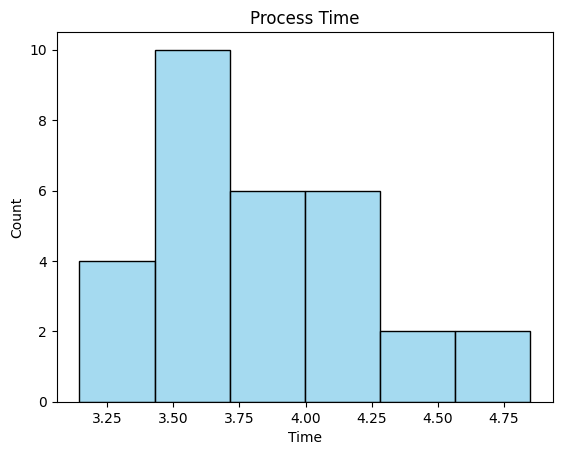

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(t,color= 'skyblue')
plt.xlabel('Time')
plt.ylabel('Count')

# 플롯의 제목 설정
plt.title('Process Time')